# Initial exploration

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import seaborn as sns
import matplotlib.image as mpimg

In [3]:
import models
import metrics
import loadData
import trainers

import torch
import wandb
wandbapi = wandb.Api()

### First things first, achieving reasonable performance from the U Net trained on ground truth data. 

In [19]:
wandbapi.run('lrast/noiseRemoval/32x91b1q')

<Run lrast/noiseRemoval/32x91b1q (finished)>

The training loss achieves reasonably low values, but the validation never does. In fact, after an early dip, the validation performance gets steadily worse.

In [10]:
initialTraining = models.UNet.load_from_checkpoint( 'lightning_logs/firstTry/epoch=23-step=240.ckpt' )
initialTraining.setup()

In [11]:
testResults = initialTraining.forward( initialTraining.data.test_noisy )

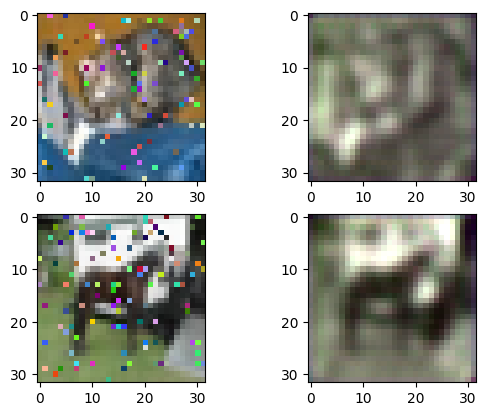

In [12]:
def imshow_custom(image):
    plt.imshow(image.permute([1,2,0]).detach())

plt.subplots(2,2)
plt.subplot(2,2,1); imshow_custom( initialTraining.data.test_noisy[0] )
plt.subplot(2,2,2); imshow_custom( testResults[0] )
plt.subplot(2,2,3); imshow_custom( initialTraining.data.test_noisy[20] )
plt.subplot(2,2,4); imshow_custom( testResults[20] )

The peak validation performance is achieved when the network outputs a fairly constant value. Somewhat surprising, since the UNet does have access to the ground truth at the output. Also, it is better to just pass through the noise:

In [13]:
print('Noisy to Ground MSE:', initialTraining.pixelLoss(initialTraining.data.test_noisy, 
                                                        initialTraining.data.test_base) )
print('Reconstruction Ground MSE:', initialTraining.pixelLoss( testResults,
                                                        initialTraining.data.test_base) )

Noisy to Ground MSE: tensor(0.0147)
Reconstruction Ground MSE: tensor(0.0108, grad_fn=<MseLossBackward0>)


This looks like about the right reconstruction difference considering the validation performance. It does beat not trying to denoise at all, but not by much.

It is a bit surprising that this is the best that you can do. In particular, the colors of the reconstructions are all very dull. I wonder if this is due to the [0,1] encoding that I''m forcing on the network. Maybe a nonlinearity would be better.

In [4]:
wandbapi.run('lrast/noiseRemoval/28j6owca')

<Run lrast/noiseRemoval/28j6owca (finished)>

Already validation looks massively improved

In [5]:
nlinTraining = models.UNet.load_from_checkpoint( 'lightning_logs/firstTry_nlin/epoch=111-step=1120.ckpt' )
nlinTraining.setup()

testResults = nlinTraining.forward( nlinTraining.data.test_noisy )

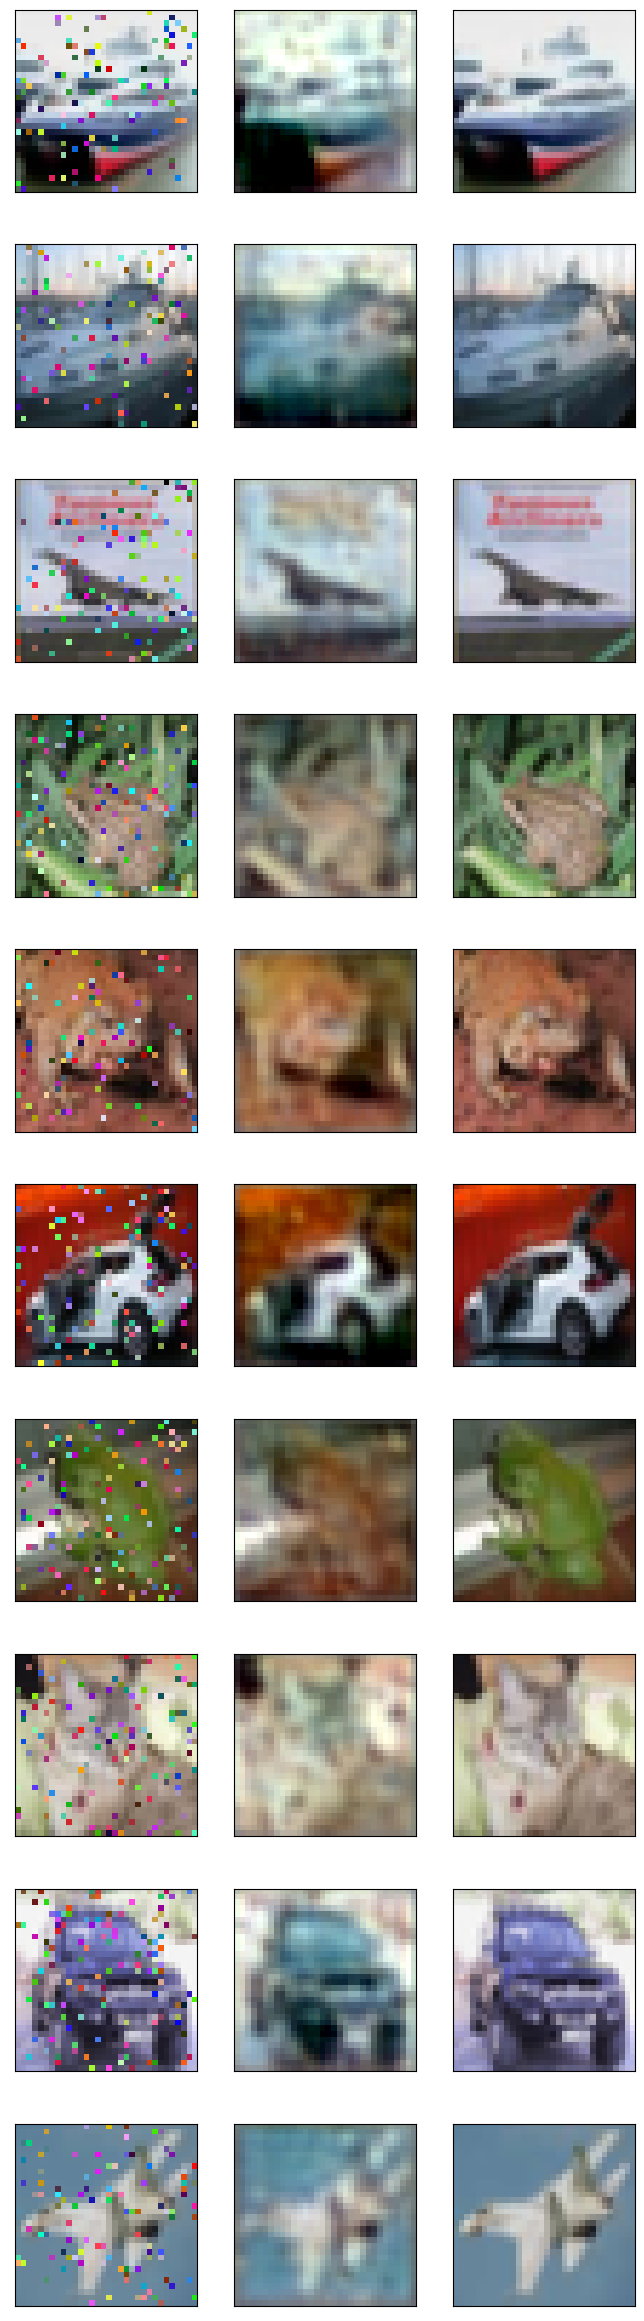

In [22]:
def imshow_custom(image):
    plt.imshow(image.permute([1,2,0]).detach())

figsize(8, 30)
plt.subplots(10,3)

for i in range(1, 11):
    base = 3*(i-1) + 1
    plt.subplot(10,3,base)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( nlinTraining.data.test_noisy[i] )
    
    plt.subplot(10,3,base+1)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( testResults[i] )
    
    plt.subplot(10,3,base+2)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( nlinTraining.data.test_base[i] )



In [24]:
print('Noisy to Ground MSE:', nlinTraining.pixelLoss(nlinTraining.data.test_noisy, 
                                                        nlinTraining.data.test_base) )
print('Reconstruction Ground MSE:', nlinTraining.pixelLoss( testResults,
                                                        nlinTraining.data.test_base) )

Noisy to Ground MSE: tensor(0.0147)
Reconstruction Ground MSE: tensor(0.0061, grad_fn=<MseLossBackward0>)


Reasonable but not great. The colors are still dimmer, and the features are blurrier. This seems good enough for an initial sweep. In particular, I'd like to see

1. Generalization performance vs # of images and # of noisy examples

2. Reconstruction at zero noise. (Does this reconstruct perfectly as it should?)

3. Of course, the noise.

## Exploring different loss functions

In [27]:
BCETraining = models.UNet.load_from_checkpoint( 'lightning_logs/firstTry_BCELoss/epoch=111-step=1120.ckpt' )
BCETraining.setup()

testResults = BCETraining.forward( BCETraining.data.test_noisy )

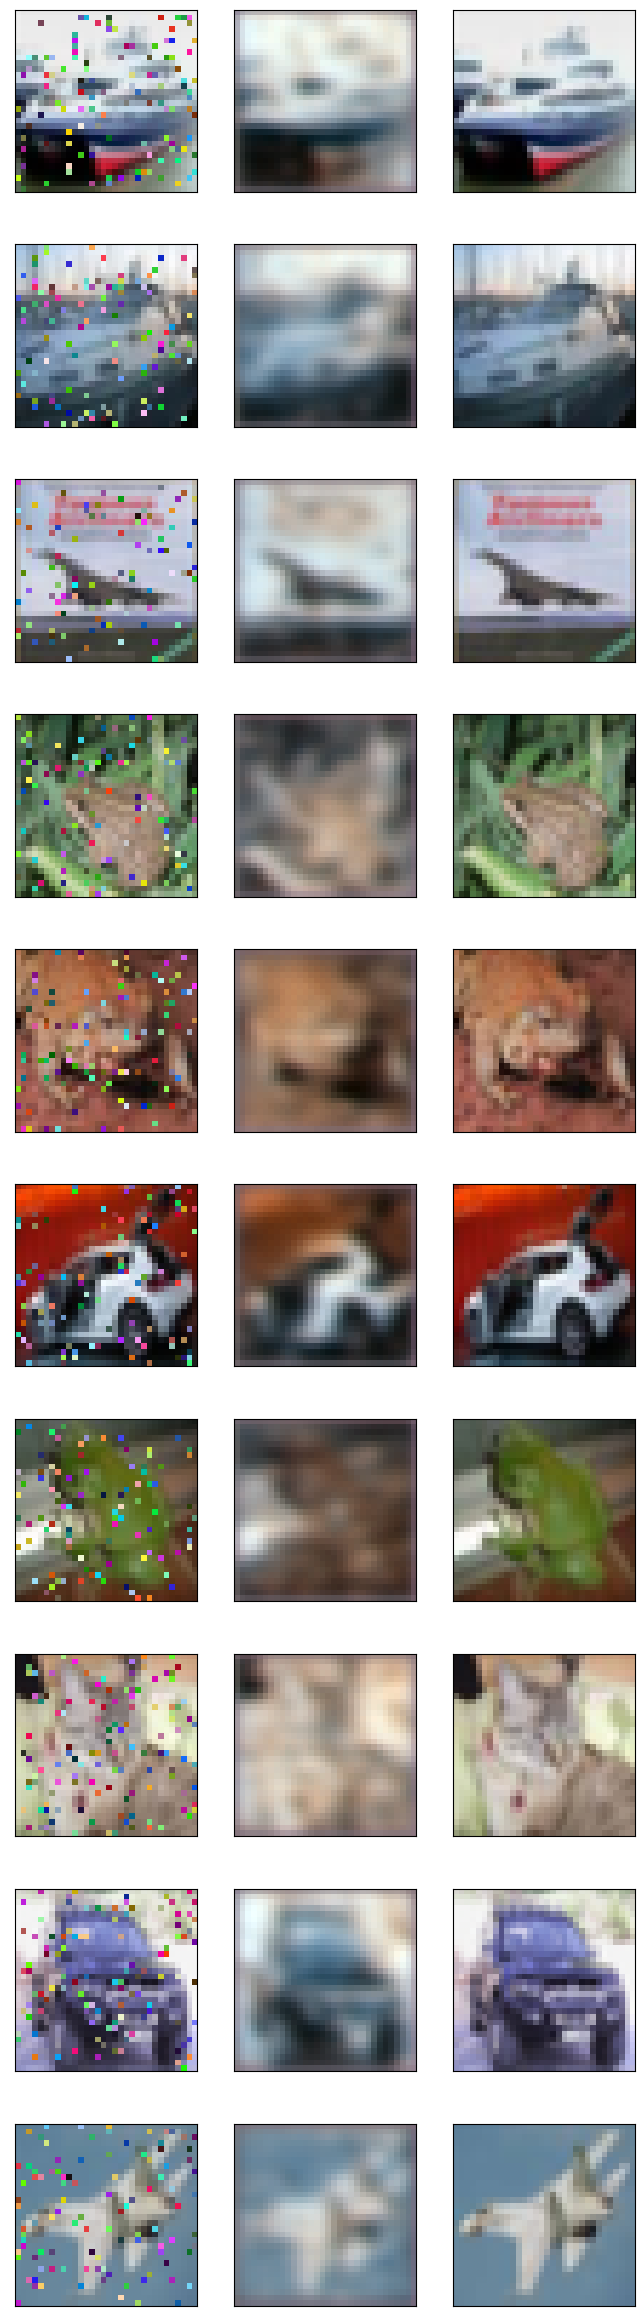

In [28]:
def imshow_custom(image):
    plt.imshow(image.permute([1,2,0]).detach())

figsize(8, 30)
plt.subplots(10,3)

for i in range(1, 11):
    base = 3*(i-1) + 1
    plt.subplot(10,3,base)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( BCETraining.data.test_noisy[i] )
    
    plt.subplot(10,3,base+1)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( testResults[i] )
    
    plt.subplot(10,3,base+2)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( BCETraining.data.test_base[i] )


Unoptimized, BCE loss is visually less appealing than MSE loss. In particular, the colors really don't work. I think this must have to do with the low loss magnitude with middle value pixels.

In [30]:
L1Training = models.UNet.load_from_checkpoint( 'lightning_logs/firstTry_L1Loss/best.ckpt' )
L1Training.setup()

testResults = L1Training.forward( L1Training.data.test_noisy )

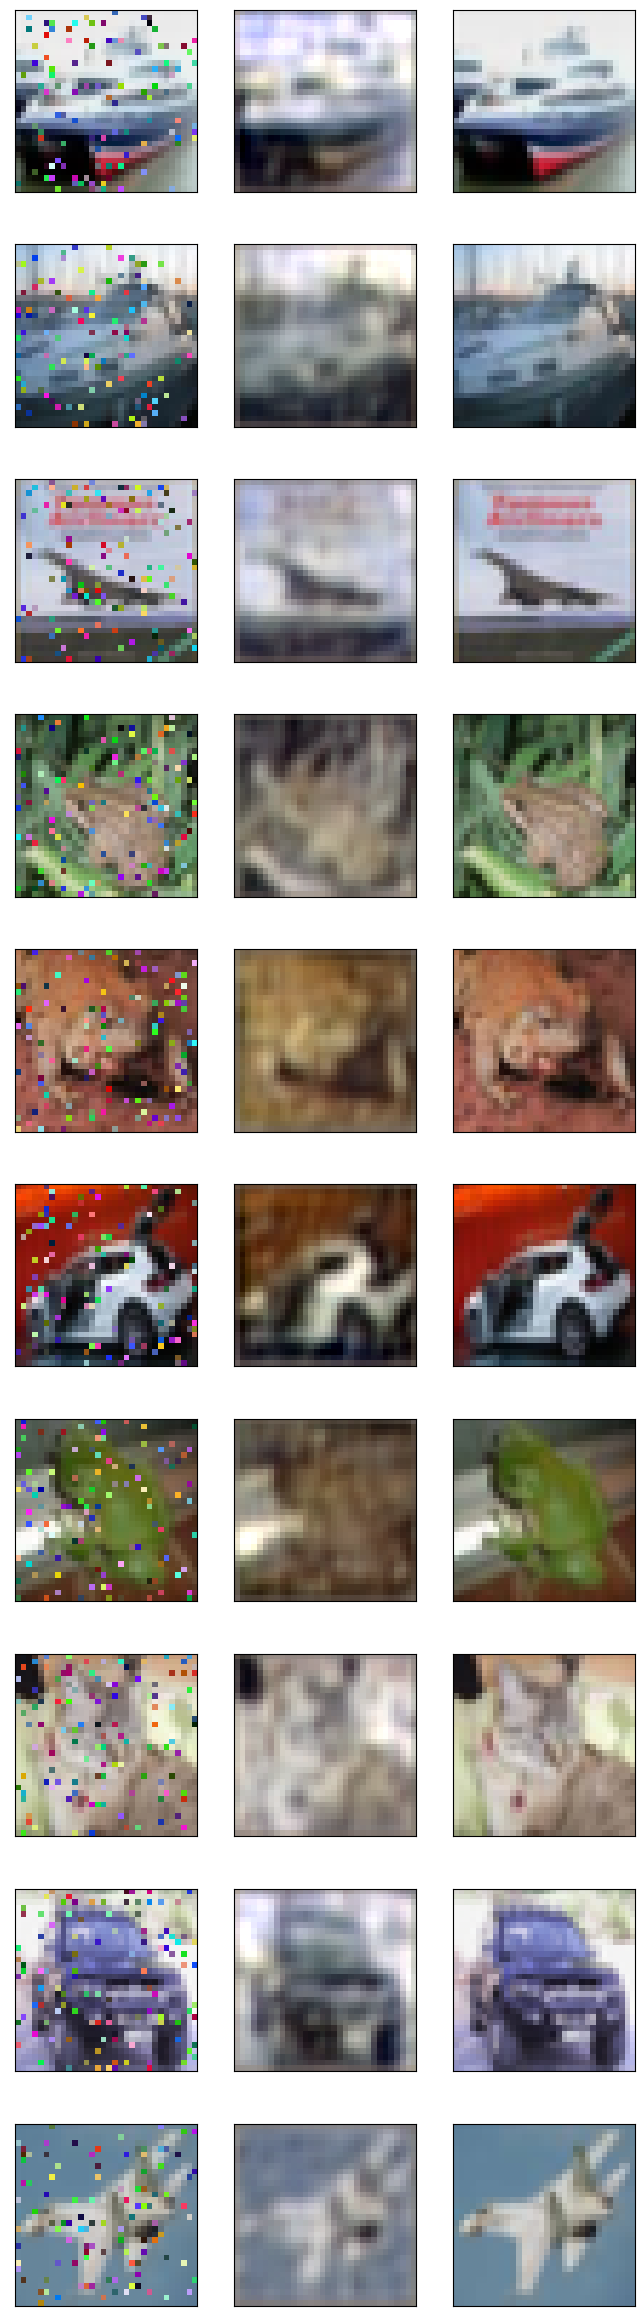

In [31]:
def imshow_custom(image):
    plt.imshow(image.permute([1,2,0]).detach())

figsize(8, 30)
plt.subplots(10,3)

for i in range(1, 11):
    base = 3*(i-1) + 1
    plt.subplot(10,3,base)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( L1Training.data.test_noisy[i] )
    
    plt.subplot(10,3,base+1)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( testResults[i] )
    
    plt.subplot(10,3,base+2)
    ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
    imshow_custom( L1Training.data.test_base[i] )


L1 loss is similarly OK. Not really sure how to judge it relative to L2.... The colors are still dulled, fine scale details are missing, and there are certainly artifacts.

One necessary factor for a loss function is that perfect reproduction should be achieved in the noise free case. Trying this.